In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import LabelEncoder

### とりあえず2日目で学んだ内容で、学習に使うデータはDay1から変えずに、どのくらい精度などが変わるか試してみる

### 1. データの読み込み

In [2]:
df_origin = pd.read_csv("../ks-projects-201801.csv")

# データ表示
display(df_origin.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### 2. 学習に使うデータを作成

In [3]:
# 「成功」か「失敗」だけのレコードを抽出(成功か失敗かで完了してしまっているデータ)
df_success_or_failed = df_origin[(df_origin["state"] == "successful") | (df_origin["state"] == "failed")]

# カテゴリ変数の数値化
# 不要だと思われる「ID」と「name」カラムは削除する
df_success_or_failed = df_success_or_failed.drop("ID", axis = 1)
df_success_or_failed = df_success_or_failed.drop("name", axis = 1)

In [4]:
# LabelEncoderでカテゴリ変数を数値化
le = LabelEncoder()
# 「fit」と「transform」を分けることも出来る（fitで変換式を保存しておいて、fitの戻り値を使いまわすことができる）
# 数値化した列には「_class」を付加した列としてセットする
df_success_or_failed["category_class"] = le.fit_transform(df_success_or_failed["category"])
df_success_or_failed["main_category_class"] = le.fit_transform(df_success_or_failed["main_category"])
df_success_or_failed["currency_class"] = le.fit_transform(df_success_or_failed["currency"])
df_success_or_failed["state_class"] = le.fit_transform(df_success_or_failed["state"])
df_success_or_failed["country_class"] = le.fit_transform(df_success_or_failed["country"])

# カラムを並び変えたDataFrame作成
df_success_or_failed = df_success_or_failed.loc[:, ["category", "category_class",
                                                       "main_category", "main_category_class",
                                                        "state", "state_class",
                                                       "currency", "currency_class",
                                                       "deadline", "goal", "launched", "pledged",
                                                       "backers",
                                                       "country", "country_class",
                                                       "usd pledged", "usd_pledged_real", "usd_goal_real"]]
# 見やすいようにソートする
df_success_or_failed = df_success_or_failed.sort_values(by=["category_class", "main_category_class", "state_class"], 
                                                        ascending=[True, True, False])

#### 今回はサポートベクターマシンで学習するので、目的変数を「-1」 or 「１」に変換する

In [5]:
# 失敗(failed)が「０」なので、-1に変換
df_success_or_failed.loc[df_success_or_failed["state_class"] == 0, "state_class"] = -1
display(df_success_or_failed.head())
display(df_success_or_failed.tail())

,category,category_class,main_category,main_category_class,state,state_class,currency,currency_class,deadline,goal,launched,pledged,backers,country,country_class,usd pledged,usd_pledged_real,usd_goal_real
1000,3D Printing,0,Technology,13,successful,1,USD,13,2014-09-10,25000.0,2014-08-11 17:03:52,118923.50,290,US,22,118923.50,118923.50,25000.00
1084,3D Printing,0,Technology,13,successful,1,EUR,4,2015-06-11,30000.0,2015-05-12 09:42:41,40581.00,149,DE,5,45283.87,45531.66,33659.83
5028,3D Printing,0,Technology,13,successful,1,CAD,1,2013-10-20,50000.0,2013-09-20 23:21:14,651091.16,4420,CA,3,636502.52,623770.03,47901.90
8868,3D Printing,0,Technology,13,successful,1,CAD,1,2016-08-24,25000.0,2016-07-26 22:45:15,216288.98,84,CA,3,27244.69,167874.09,19403.91
10888,3D Printing,0,Technology,13,successful,1,USD,13,2017-04-24,30000.0,2017-03-21 17:20:36,254412.00,266,US,22,56808.00,254412.00,30000.00


,category,category_class,main_category,main_category_class,state,state_class,currency,currency_class,deadline,goal,launched,pledged,backers,country,country_class,usd pledged,usd_pledged_real,usd_goal_real
373961,Zines,158,Publishing,12,failed,-1,AUD,0,2017-01-01,3500.0,2016-12-02 02:24:59,500.00,17,AU,1,211.36,366.84,2567.87
374488,Zines,158,Publishing,12,failed,-1,GBP,5,2016-02-27,6500.0,2016-01-28 14:39:45,246.00,15,GB,9,352.81,348.28,9202.63
374627,Zines,158,Publishing,12,failed,-1,USD,13,2017-04-06,500.0,2017-03-24 22:40:52,23.00,2,US,22,23.00,23.00,500.00
375812,Zines,158,Publishing,12,failed,-1,GBP,5,2016-04-29,3000.0,2016-03-11 00:09:05,362.00,18,GB,9,513.49,529.05,4384.36
376778,Zines,158,Publishing,12,failed,-1,CAD,1,2014-08-04,3000.0,2014-06-30 21:22:06,922.11,32,CA,3,864.59,844.73,2748.26


In [6]:
# 事前にわからない情報を削除
for col in ["pledged", "backers", "usd pledged", "usd_pledged_real", "goal"]:
    df_success_or_failed = df_success_or_failed.drop(col, axis = 1)

# クラウドファンディング期間という新しい説明変数を作成
launched_time = pd.to_datetime(df_success_or_failed["launched"], format = "%Y-%m-%d %H:%M:%S")
deadline_time = pd.to_datetime(df_success_or_failed["deadline"], format = "%Y-%m-%d %H:%M:%S")
df_success_or_failed["term_days"] = (deadline_time - launched_time).dt.days

In [7]:
# カテゴリ変数をOne-hotベクトル化
category_class_dummy = pd.get_dummies(df_success_or_failed["category_class"], prefix="category")
main_category_class_dummy = pd.get_dummies(df_success_or_failed["main_category_class"], prefix="main_category")
currency_class_dummy = pd.get_dummies(df_success_or_failed["currency_class"], prefix="currency")
country_class_dummy = pd.get_dummies(df_success_or_failed["country_class"], prefix="country")

# 学習用データ
# One-hotベクトルにしたものから「main_category_class_dummy」と「currency_class_dummy」だけ使ってみる
df_for_learning = pd.concat([df_success_or_failed, main_category_class_dummy, currency_class_dummy], axis = 1)

# 不要なカラム削除
for col in ["category", "main_category", "state", "currency", "deadline", 
            "launched", "country", "category_class", "main_category_class", "currency_class", "country_class"]:
    df_for_learning = df_for_learning.drop(col, axis = 1)
    
df_for_learning.head()

,state_class,usd_goal_real,term_days,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,...,currency_4,currency_5,currency_6,currency_7,currency_8,currency_9,currency_10,currency_11,currency_12,currency_13
1000,1,25000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1084,1,33659.83,29,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5028,1,47901.90,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8868,1,19403.91,28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10888,1,30000.00,33,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### データを学習用とテスト用に分ける

In [8]:
# 目的変数を除いたデータ
X = df_for_learning.iloc[:, 1:len(df_for_learning.columns)].values
# 目的変数
Y = df_for_learning["state_class"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)

#### データ標準化

In [9]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# usd_goal_real
X_train[:, 0] = stdsc.fit_transform(X_train[:, 0].reshape(-1, 1)).reshape(-1)
X_test[:, 0]  = stdsc.transform(X_test[:, 0].reshape(-1, 1)).reshape(-1)

# term_days
X_train[:, 1] = stdsc.fit_transform(X_train[:, 1].reshape(-1, 1)).reshape(-1)
X_test[:, 1]  = stdsc.transform(X_test[:, 1].reshape(-1, 1)).reshape(-1)

In [10]:
from statistics import mean, median,variance,stdev

# 標準化できたことを確認
print("training data : usd_goal_real: mean={:3f}, variance={:3f}".format(mean(X_train[:, 0]), variance(X_train[:, 0])))
print("training data : term_days: mean={:3f}, variance={:3f}".format(mean(X_train[:, 1]), variance(X_train[:, 1])))
print("test data : usd_goal_real: mean={:3f}, variance={:3f}".format(mean(X_test[:, 0]), variance(X_test[:, 0])))
print("test data : term_days: mean={:3f}, variance={:3f}".format(mean(X_test[:, 1]), variance(X_test[:, 1])))

training data : usd_goal_real: mean=0.000000, variance=1.000004
training data : term_days: mean=0.000000, variance=1.000004
test data : usd_goal_real: mean=0.003044, variance=0.996475
test data : term_days: mean=0.008570, variance=1.019054


### 3. 学習

In [ ]:
%%time

# グリッドサーチだと丸１日以上かかっても学習が完了しなかったので中止
## グリッドサーチで最適なハイパーパラメータ探索してみる
#parameters = {"kernel":["linear", "rbf"], "C":[0.1, 1, 10]}
#model = SVC()
#clf = GridSearchCV(model, parameters, cv = 2,)
#clf.fit(X_train, Y_train)
#print(clf.best_params_, clf.best_score_)

In [ ]:
## 最適なハイパーパラメータで再学習
#clf_best = SVC(**clf.best_params_)
#clf_best.fit(X_train, Y_train)
#print("識別精度=",clf2.score(X_test, y_test))

In [11]:
%%time

# SVMの実行
C = 10
kernel = "rbf"
gamma = 1
clf = SVC(C = C, kernel = kernel, gamma = gamma)
clf.fit(X_train, Y_train)

CPU times: user 4h 22min 39s, sys: 499 ms, total: 4h 22min 39s
Wall time: 4h 22min 39s


In [12]:
# ラベルを予測
Y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, Y_pred)

# 表示
print("対数尤度 = {:.3f}".format(- log_loss(Y_test, Y_pred)))
print("Accuracy(正答率) = {:.3f}%".format(accuracy * 100))
print("Precision(適合率) = {:.3f}%".format(precision[1] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[1] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[1] * 100))

対数尤度 = -12.212
Accuracy(正答率) = 64.643%
Precision(適合率) = 60.161%
Recall(再現率) = 35.824%
F1-score(F1値) = 44.907%


In [13]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(Y_test, Y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=["正解 = failed", "正解 = successful"], 
                        columns=["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,33322,6330
正解 = successful,17124,9559


#### ハイパーパラメータの組み合わせを少なくしてグリッドサーチ

In [14]:
# SVMはすべてのデータを使うと、学習にめちゃくちゃ時間がかかったので
# 学習データを更にランダム抽出する
import random

random.seed(1234)
# 抽出行
index = random.sample(range(len(X_train)), k = int(len(X_train) * 0.3)) # 30%抽出
# データランダム抽出
X_train = X_train[index, :]
Y_train = Y_train[index]

In [15]:
print(len(X_train))
print(len(Y_train))

79602
79602


In [16]:
%%time

# グリッドサーチで最適なハイパーパラメータ探索してみる
parameters = {"kernel":["rbf"], "C":[0.1, 1]}
model = SVC()
clf = GridSearchCV(model, parameters, cv = 2,)
clf.fit(X_train, Y_train)
print(clf.best_params_, clf.best_score_)

{'C': 1, 'kernel': 'rbf'} 0.6286902339137208
CPU times: user 19min 34s, sys: 296 ms, total: 19min 35s
Wall time: 19min 35s


In [17]:
%%time

# 最適なハイパーパラメータで再学習
clf_best = SVC(**clf.best_params_)
clf_best.fit(X_train, Y_train)
print("識別精度=", clf_best.score(X_test, Y_test))

識別精度= 0.6279339715082536
CPU times: user 10min 26s, sys: 140 ms, total: 10min 26s
Wall time: 10min 26s


In [18]:
# ラベルを予測
Y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, Y_pred)

# 表示
print("対数尤度 = {:.3f}".format(- log_loss(Y_test, Y_pred)))
print("Accuracy(正答率) = {:.3f}%".format(accuracy * 100))
print("Precision(適合率) = {:.3f}%".format(precision[1] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[1] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[1] * 100))

対数尤度 = -12.851
Accuracy(正答率) = 62.793%
Precision(適合率) = 58.034%
Recall(再現率) = 27.100%
F1-score(F1値) = 36.947%


In [19]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(Y_test, Y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=["正解 = failed", "正解 = successful"], 
                        columns=["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,34423,5229
正解 = successful,19452,7231


### Day1の結果との比較
Day1の結果は以下の通りであった。
>対数尤度 = -13.577  
Accuracy(正答率) = 60.691%  
Precision(適合率) = 51.057%  
Recall(再現率) = 64.553%  
F1-score(F1値) = 57.017%  

Day1でのロジスティック回帰モデルでの分類から、学習に使うデータはDay1と同じで、  
・データ標準化  
・サポートベクターマシンでの分類  
・ホールドアウト法で汎化性能の評価  
を行った。  
結果、Recallがとても低い値になっていることを確認した。  
成功と失敗を分類するための説明変数をもっと効果的なものを考える必要があるかと思った。

# ここからは新たな説明変数を作り出すために、データを色々な形で分析した記録

### ・英語圏の方が成功しやすいのでは、という推測

「Kickstarterとは2009年に設立されたアメリカ合衆国の民間営利企業」らしいので、英語圏のプロジェクトの方が成功しやすそうな気がする。
とりあえず国別に成功したデータと失敗したデータに分けて可視化してみる

In [20]:
country_x = df_origin["country"].value_counts().index
country_y = df_origin["country"].value_counts().values

#### 国ごとのプロジェクト件数

Text(0,0.5,'Number')

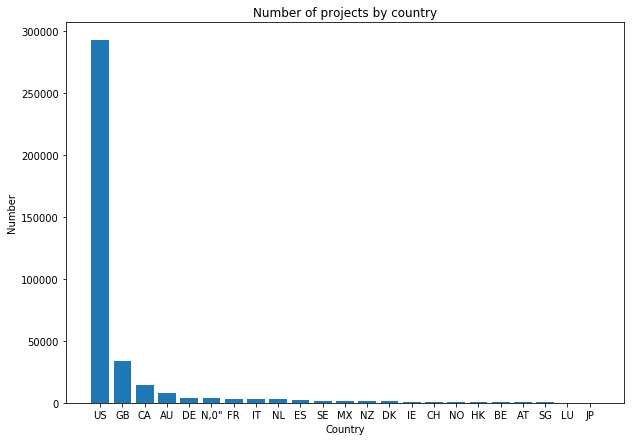

In [21]:
plt.figure(figsize=(10, 7))
plt.bar(np.arange(0, len(country_x)), country_y, tick_label = country_x,align = "center")
plt.title("Number of projects by country")
plt.xlabel("Country")
plt.ylabel("Number")

#### 円グラフで国ごとのプロジェクト件数の割合を表示

([<matplotlib.patches.Wedge at 0x7fe6d2697b00>,
 [Text(-0.831476,0.720172,'US'),
  Text(0.451129,-1.00324,'GB'),
  Text(0.807532,-0.746922,'CA'),
  Text(0.932584,-0.583341,'AU'),
  Text(0.985988,-0.487676,'DE'),
  Text(1.01605,-0.421478,'N,0"'),
  Text(1.03801,-0.364067,'FR'),
  Text(1.05436,-0.313567,'IT'),
  Text(1.06811,-0.262966,'NL'),
  Text(1.07835,-0.217156,'ES'),
  Text(1.08501,-0.180959,'SE'),
  Text(1.08982,-0.149299,'MX'),
  Text(1.0934,-0.120326,'NZ'),
  Text(1.09571,-0.0970772,'DK'),
  Text(1.09712,-0.0795752,'IE'),
  Text(1.09806,-0.06526,'CH'),
  Text(1.09878,-0.0518726,'NO'),
  Text(1.09928,-0.0397818,'HK'),
  Text(1.09963,-0.0285164,'BE'),
  Text(1.09986,-0.0174396,'AT'),
  Text(1.09998,-0.00692683,'SG'),
  Text(1.1,-0.00129598,'LU'),
  Text(1.1,-0.000365107,'JP')],
 [Text(-0.453532,0.392821,'77.3%'),
  Text(0.24607,-0.54722,'8.9%'),
  Text(0.440472,-0.407412,'3.9%'),
  Text(0.508682,-0.318186,'2.1%'),
  Text(0.537811,-0.266005,'1.1%'),
  Text(0.554209,-0.229897,'1.0%'

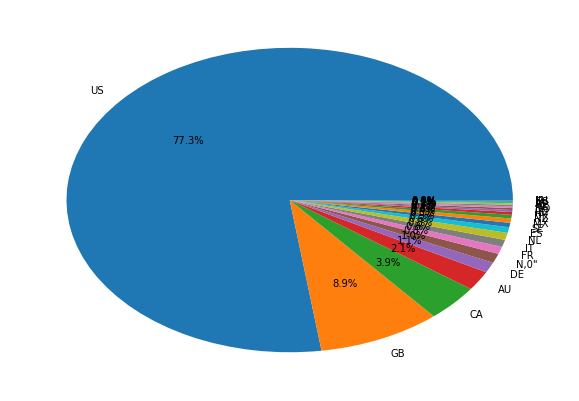

In [22]:
plt.figure(figsize=(10, 7))
plt.pie(country_y, autopct="%.1f%%", labels = country_x)

77%はアメリカで、ついでイギリス(GB)、カナダ(CA)での開催となっている。   
上位3つで全体の9割を占めている。

#### 国ごとの「成功」、「失敗」の件数を可視化

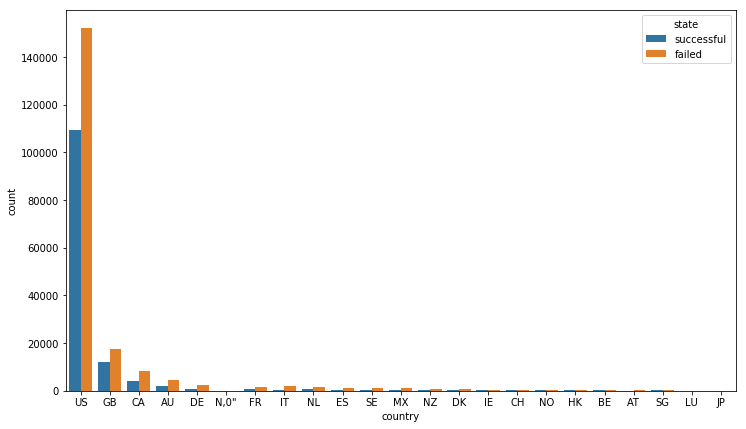

In [23]:
plt.figure(figsize=(12, 7))
sns.countplot(x = "country", hue = "state", hue_order = ["successful", "failed"], order = country_x, data = df_origin)

#### 国ごとの「成功」、「失敗」の割合を可視化

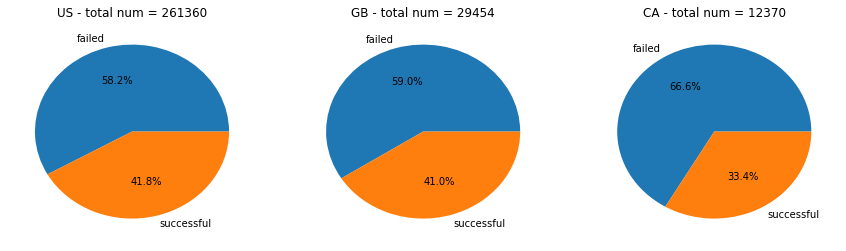

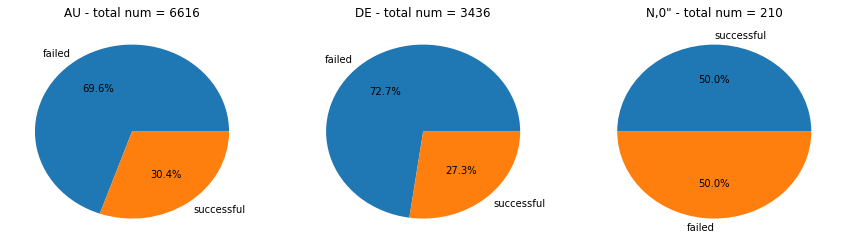

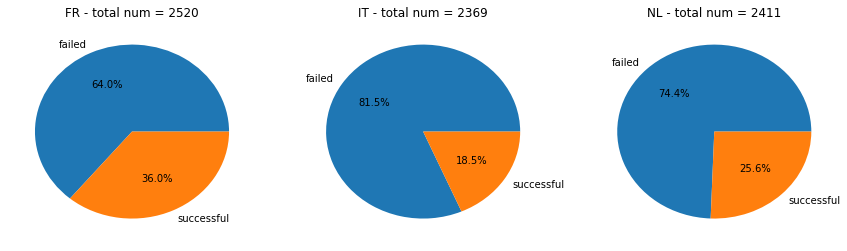

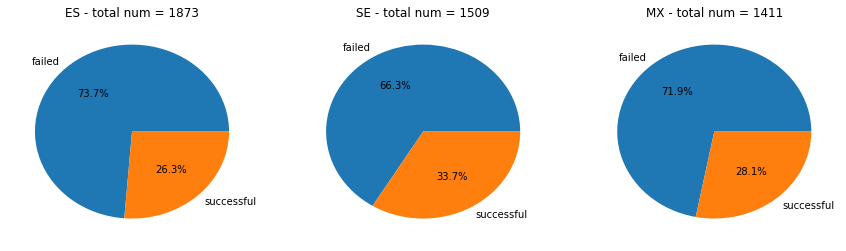

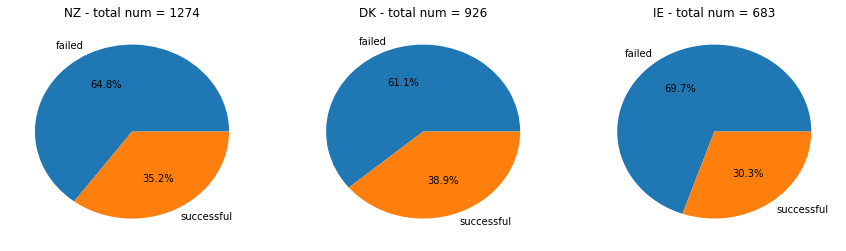

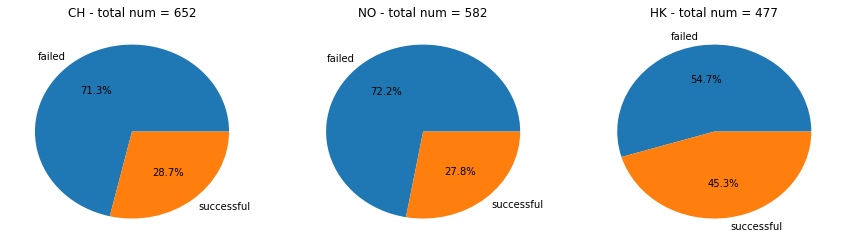

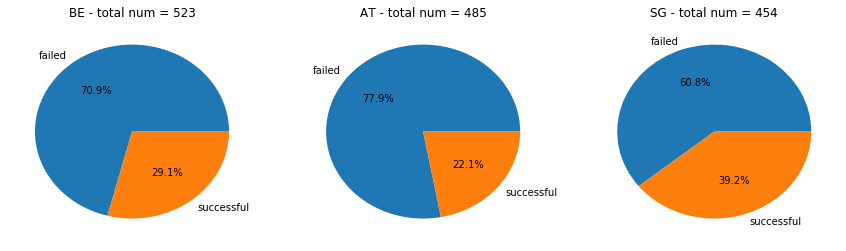

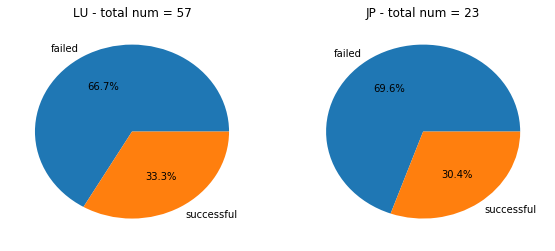

In [24]:
# 国ごとに「成功」、「失敗」の割合を可視化
# 円グラフで可視化
country_pie_graph_row = len(country_x) / 3
country_pie_graph_index = 0

plt.figure(figsize=(20, 4))

for country in country_x:
    # ある国のデータ
    df_country = df_origin[df_origin["country"] == country]
    # 「成功」と「失敗」のみのデータ
    df_country_success_or_failed = df_country[(df_country["state"] == "successful") | (df_country["state"] == "failed")]
    country_success_or_failed_x = df_country_success_or_failed["state"].value_counts().index
    country_success_or_failed_y = df_country_success_or_failed["state"].value_counts().values
    
    # 円グラフ描画
    plt.subplot(1, 4, country_pie_graph_index % 3 + 1)
    plt.title("{} - total num = {}".format(country, len(df_country_success_or_failed)))
    plt.pie(country_success_or_failed_y, autopct="%.1f%%", labels = country_success_or_failed_x)
    
    country_pie_graph_index = country_pie_graph_index + 1
    
    # 1行に3つずつグラフ描画
    if (country_pie_graph_index % 3) == 0:
        #plt.legend(loc='best')
        plt.show()
        plt.figure(figsize=(20, 4))
    # 最後
    elif country_pie_graph_index == len(country_x):
        #plt.legend(loc='best')
        plt.show()

### 結論  
円グラフより、英語圏の方が成功率が高い傾向がある。  
>英語圏の成功率は30%以上(US、GBは40%を超えている。)  
>逆にIT(イタリア)、ES(スペイン)、AT(オーストリア)などの英語圏以外の国は成功率が30%未満となっている  

よって英語圏かそうでないかの説明変数の追加を検討する。  
FRは英語圏ではないが、成功率が高いので英語圏に含めたほうがいいかも。  

### ・カテゴリで成功率は違うのかという推測
#### カテゴリごとの成功率を可視化

In [25]:
df_success_or_failed = df_origin[(df_origin["state"] == "successful") | (df_origin["state"] == "failed")]

main_category_x = df_success_or_failed["main_category"].value_counts().index
df_success_rate = pd.DataFrame({"main_category":main_category_x.values,
                                   "success_rate":np.zeros(len(main_category_x.values)),
                                    "success_count":np.zeros(len(main_category_x.values)),
                                    "failed_count":np.zeros(len(main_category_x.values))})

# メインカテゴリごとの成功割合を計算した結果のDataFrameを作成
# 成功割合 = 成功した件数 / あるカテゴリの成功した件数と失敗した件数の総和
row_index = 0
for main_category in main_category_x:
    df_main_category = df_success_or_failed[df_success_or_failed["main_category"] == main_category]
    df_main_category_success = df_main_category[df_main_category["state"] == "successful"]
    df_main_category_failed = df_main_category[df_main_category["state"] == "failed"]
    df_success_rate.loc[row_index, "success_rate"] = (len(df_main_category_success) / len(df_main_category)) * 100
    df_success_rate.loc[row_index, "success_count"] = len(df_main_category_success)
    df_success_rate.loc[row_index, "failed_count"] = len(df_main_category_failed)
    row_index = row_index + 1    
    #plt.plot(x, y_true, linestyle='--', linewidth=3, color='orange', label='True model')

# 成功率でソート
df_success_rate = df_success_rate.sort_values(by=["success_rate"], 
                                                        ascending=[False])
df_success_rate.index = range(len(df_success_rate))

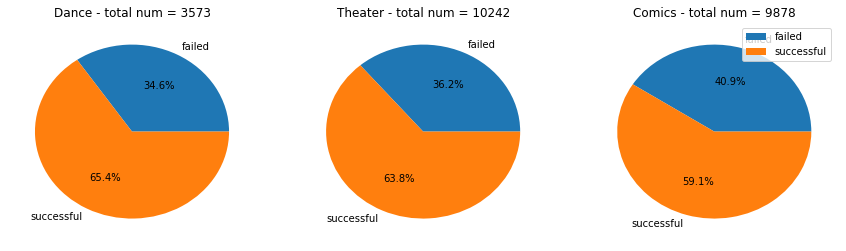

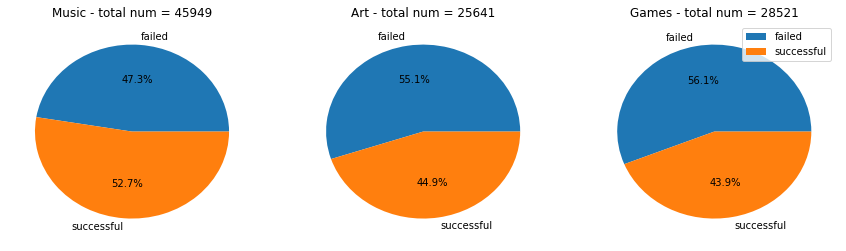

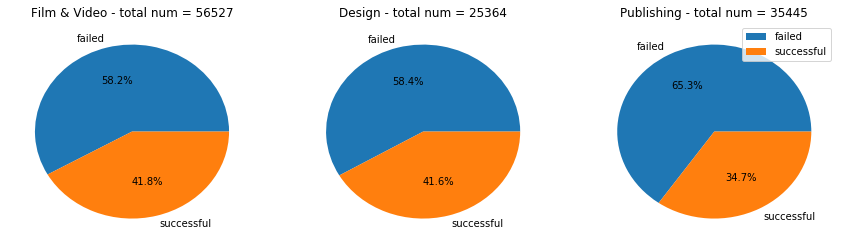

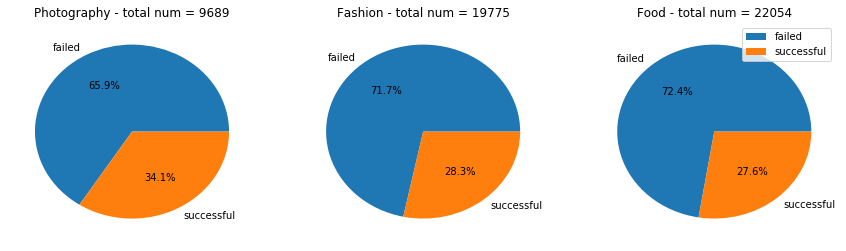

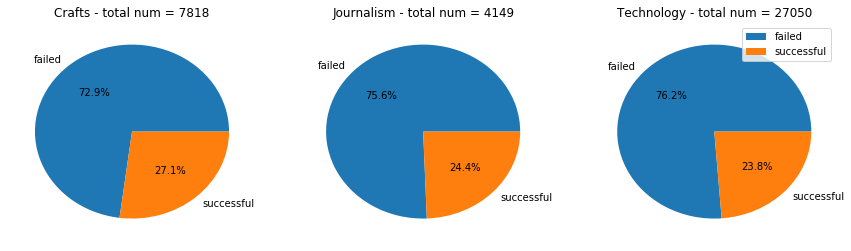

<Figure size 1440x288 with 0 Axes>

In [26]:
# カテゴリごとの成功/失敗の割合を円グラフ表示
plt.figure(figsize=(20, 4))

for i in range(len(df_success_rate)):
    
    # 円グラフ描画
    plt.subplot(1, 4, i % 3 + 1)
    plt.title("{} - total num = {}".format(df_success_rate.loc[i, "main_category"], 
                                (int)(df_success_rate.loc[i, "success_count"] + df_success_rate.loc[i, "failed_count"])))
    plt.pie(df_success_rate.loc[i, ["failed_count", "success_count"]].values,
            autopct="%.1f%%",
            labels = ["failed", "successful"])
    
    # 1行に3つずつグラフ描画
    if ((i + 1) % 3) == 0:
        plt.legend(loc='best')
        plt.show()
        plt.figure(figsize=(20, 4))
    # 最後
    elif (i + 1) == len(df_success_rate):
        plt.legend(loc='best')
        plt.show()

### 結論 
カテゴリごとで成功する割合が異なることがわかった。  
これだけで判断するのは安易かもしれないが、成功割合の低い層と、中間くらいの層、上位層とで区分する説明変数の追加を検討する。  
下位層：40%未満  
中間層：40%以上、60%未満  
上位層：60%以上  
「Comics」は上位層とする(ほぼ60%なので)

### Kickstarterの近年の成功/失敗の傾向を観察する

In [27]:
# プロジェクト締切日(deadline)で年別に成功/失敗を可視化する
df_success_or_failed = df_origin[(df_origin["state"] == "successful") | (df_origin["state"] == "failed")]
# TODO 
# SettingWithCopyWarningが出る
#df_success_or_failed["Year"] = pd.to_datetime(df_success_or_failed["deadline"], format = "%Y-%m-%d %H:%M:%S").dt.year
# SettingWithCopyWarningを回避するためだけのcopy。時間が出来たら原因を調べたい
df_success_or_failed = df_success_or_failed.copy()
df_success_or_failed["Year"] = pd.to_datetime(df_success_or_failed["deadline"], format = "%Y-%m-%d %H:%M:%S").dt.year

#### 年ごとのプロジェクト件数

Text(0,0.5,'Number')

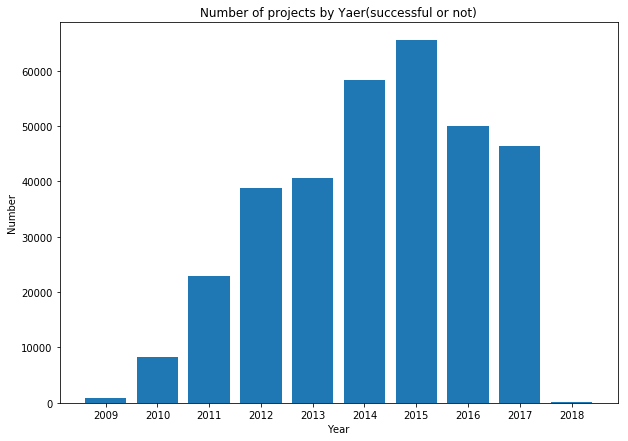

In [28]:
df_Year = pd.DataFrame({"Year":df_success_or_failed["Year"].value_counts().index, 
                   "Count":df_success_or_failed["Year"].value_counts().values})
df_Year = df_Year.sort_values(by = ["Year"], ascending = [True])

plt.figure(figsize=(10, 7))
plt.bar(np.arange(0, len(df_Year)), df_Year["Count"].values,
                                        tick_label = df_Year["Year"].values, align = "center")
plt.title("Number of projects by Yaer(successful or not)")
plt.xlabel("Year")
plt.ylabel("Number")

#### 年ごとのプロジェクト成功件数と失敗件数

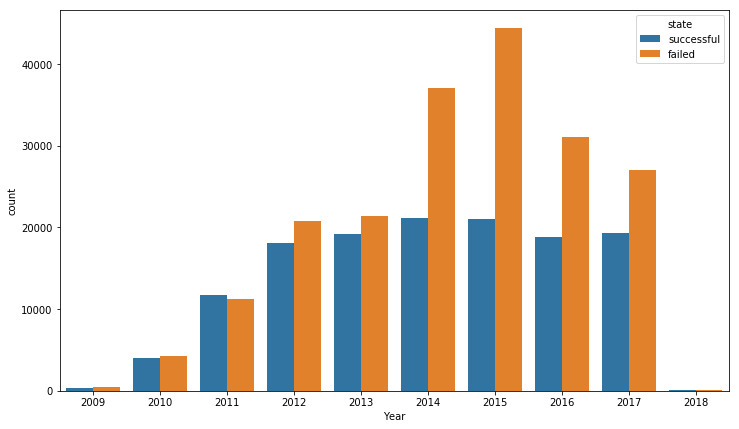

In [29]:
plt.figure(figsize=(12, 7))
sns.countplot(x = "Year", hue = "state", hue_order = ["successful", "failed"], order = df_Year["Year"].values, data = df_success_or_failed)

2013年までは約半数のプロジェクトが成功している。  
2014年、2015年には2013年までと比べて、総プロジェクト件数は伸びたが、成功したプロジェクトは  
それほど伸びていない。  
その傾向を見てか、2015年をピークにプロジェクト件数は減少傾向  
ブームに乗った準備不足のプロジェクトが乱立したことが原因なのか？

#### 資金調達率が30%未満の大失敗プロジェクトの割合の推移

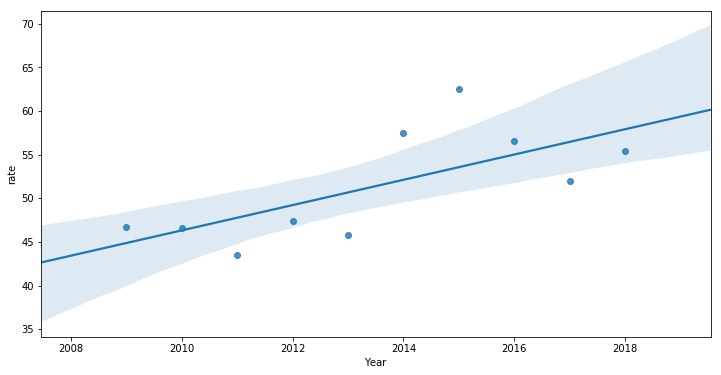

In [30]:
# 年ごとの資金調達率を可視化
# 調達率 = (usd_pledged_real / usd_goal_real) * 100
df_pledged_rate = pd.DataFrame({"Year":df_success_or_failed["Year"].values,
                                    "usd_pledged_real":df_success_or_failed["usd_pledged_real"].values,
                                    "usd_goal_real":df_success_or_failed["usd_goal_real"].values,
                                   "pledged_rate":(df_success_or_failed["usd_pledged_real"].values) / df_success_or_failed["usd_goal_real"].values * 100})

# 資金調達率が30%未満の大失敗プロジェクトの割合を年ごとに集計
df_big_failed = df_pledged_rate[df_pledged_rate["pledged_rate"] < 30]
df_big_failed_for_graph = pd.DataFrame({"Year":df_big_failed["Year"].value_counts().index,
                                           "rate":np.zeros(10)})
# 年ごとのデータを計算してセット
index = 0
for year in df_big_failed_for_graph["Year"].values:
    df_big_failed_for_graph.loc[index,"rate"] = len(df_big_failed[df_big_failed["Year"] == year]) / len(df_pledged_rate[df_pledged_rate["Year"] == year]) * 100
    index = index + 1

# Seabornで線形回帰プロット
plt.figure(figsize=(12, 6))
sns.regplot(df_big_failed_for_graph.Year, df_big_failed_for_graph.rate)

### 結論  
成功、失敗の割合の変化が大きい2014年以降、以前で分けて考えたほうがよいのかもしれない。
資金調達率(目標額に対する調達額の割合)が低いプロジェクトも増加傾向。(2014年以降は目標の30%も集められないプロジェクトが50%を超えている)  
最近の傾向を知るためには2014年以降のデータで、学習、評価を行うほうがよいのかも。  
あるいは2014年、2015年のデータはすべて使うのではなく、一部をランダムにサンプルする。